# 3D ConvNet with Tensorflow for Shape Detection

<img src=http://www.pngmart.com/files/4/3D-PNG-Image.png width=20% align=right img>

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import sys

#### Making a sphere

In [2]:
radius = torch.tensor(10)
r2 = torch.arange(-radius, radius+1)**2
dist2 = r2[:, None, None] + r2[:, None] + r2
sphere = (dist2 <= radius**2).type(torch.int)

#### Plotting the sphere

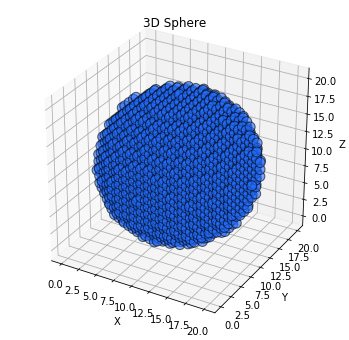

In [3]:
x, y, z = torch.where(sphere == 1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x ,y, z, alpha=.6, s=100, ec='k', color='#256EFF')
plt.title('3D Sphere')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

#### Making a square

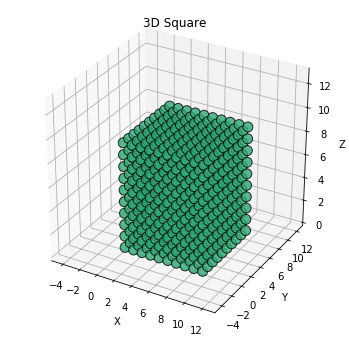

In [89]:
num = 10
square = torch.ones((num, num, num)) 
x, y, z = torch.where(square ==1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=.8, s=100, ec='k', color='#2FAA75')
ax.set_title('3D Square')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_xlim(-5, int(num*1.3)), ax.set_ylim(-5, int(num*1.3)), ax.set_zlim(0, int(num*1.3))
plt.show()

#### Making 1,000 squares

The squares will vary in size and in 3D location

In [5]:
n = 1000

In [6]:
squares = list() 
size = 24
choices = torch.tensor([6, 10])

for i in range(n):
    s = choices[torch.randint(choices.shape[0], (1,))].item()
    square = torch.ones(s, s, s) 
    a = torch.randint(0, size-s +1, (1,))
    b = torch.randint(0, size-s +1, (1,))
    c = torch.randint(0, size-s +1, (1,))

    squ = F.pad(square, mode='constant', pad=(a, size - s - a, 
                                              c, size - s - c, 
                                              b, size - s - b),
                                               value=0).type('torch.FloatTensor')
    squares.append(squ)
    
squares_array = torch.cat([i[None, ...] for i in squares])

#### Making 1,000 spheres

The spheres will vary in size and in 3D location

In [7]:
spheres = list()

for i in range(n):
    
    s = torch.randint(4, 8, (1,)).item()

    radius = s
    r2 = torch.arange(-radius, radius+1)**2
    dist2 = r2[:, None, None] + r2[:, None] + r2
    sphere = (dist2 <= radius**2).type(torch.int)
    s = sphere.shape[0]

    a = torch.randint(0, size - s, (1,))
    b = torch.randint(0, size - s, (1,))
    c = torch.randint(0, size - s, (1,))
    sph = F.pad(sphere, mode='constant', pad=(a, size - a - s, 
                                              b, size - b - s, 
                                              c, size - c - s),
                                               value=0).type('torch.FloatTensor')
    spheres.append(sph)
spheres_array = torch.cat([i[None, ...] for i in spheres])

#### Plotting both

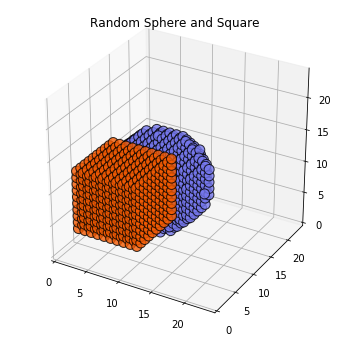

In [58]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

torch.manual_seed(42)
squ = squares_array[torch.randint(0, squares_array.shape[0], (1,))][0, :, :, :]
sph = spheres_array[torch.randint(0, spheres_array.shape[0], (1,))][0, :, :, :]

xs, ys, zs = torch.where(sph == 1)
xc, yc, zc = torch.where(squ == 1)
ax.scatter(xc ,yc, zc, alpha=.8, s=100, ec='k', color='#F35B04')
ax.scatter(xs ,ys, zs, alpha=.8, s=100, ec='k', color='#7678ED')
ax.set_xlim(0, size)
ax.set_ylim(0, size)
ax.set_zlim(0, size)
plt.title('Random Sphere and Square')
plt.show()

#### Concatenating the data

In [9]:
x = torch.cat([spheres_array, squares_array]).view(-1, 1, size, size, size)
y = torch.cat([torch.tensor(0).repeat(n), torch.tensor(1).repeat(n)])

#### Making a 3D ConvNet

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x.numpy(), y.numpy(), test_size=2e-1)

In [12]:
if torch.cuda.is_available():
    x_train = torch.from_numpy(xtrain) 
    x_test = torch.from_numpy(xtest) 
    y_train = torch.from_numpy(ytrain) 
    y_test = torch.from_numpy(ytest)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available, kys.')

Tensors successfully flushed to CUDA.


In [13]:
def flatten(w, k=3, s=1, p=0, m=True):
    return int((np.floor((w - k + 2 * p) / s) + 1) / 2 if m else 1), k, s, p, m

In [46]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        a = 32 #* 4
        b = 64 #* 4
        c = 128 #* 4
        self.conv1 = nn.Conv3d(1, a, 3)
        self.conv2 = nn.Conv3d(a, b, 3)
        self.conv3 = nn.Conv3d(b, c, 3)
        
        r = flatten(*flatten(*flatten(size, k=2)))[0]
        
        self.fc1 = nn.Linear(1**3*c, 1024) 
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2)
    
    def forward(self, x):
        x = F.max_pool3d(F.relu(self.conv1(x)), (2, 2, 2))
        x = F.max_pool3d(F.relu(self.conv2(x)), (2, 2, 2))
        x = F.max_pool3d(F.relu(self.conv3(x)), (2, 2, 2))
#         print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [47]:
net = ConvNet()

In [48]:
if torch.cuda.is_available():
    net.cuda()

In [49]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [50]:
loss_function = nn.CrossEntropyLoss()

In [51]:
class FaceTrain:
    
    def __init__(self):
        self.len = xtrain.shape[0]
        self.xtrain = xtrain
        self.ytrain = ytrain
        
    def __getitem__(self, index):
        return xtrain[index], ytrain[index]#.unsqueeze(0)
    
    def __len__(self):
        return self.len

In [52]:
class FaceTest:
    
    def __init__(self):
        self.len = xtest.shape[0]
        self.xtest = xtest
        self.ytest = ytest
        
    def __getitem__(self, index):
        return xtest[index], ytest[index]#.unsqueeze(0)
    
    def __len__(self):
        return self.len

In [53]:
train = FaceTrain()
test = FaceTest()

In [54]:
train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=16, shuffle=True)

In [98]:
epochs = 5
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train()
    for images, labels in train_loader:   
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()     
        optimizer.zero_grad()
        log_ps = net(images)
        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()        
    else:
        test_loss = 0
        accuracy = 0        
        net.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()
                log_ps = net(images)
                test_loss += loss_function(log_ps, labels)                
                # ps = torch.exp(log_ps)
                top_p, top_class = log_ps.topk(1, dim=1)
                equals = top_class.long() == labels.long().view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("[Epoch: {}/{}] ".format(e+1, epochs),
              "[Training Loss: {:.3f}] ".format(running_loss/len(train_loader)),
              "[Test Loss: {:.3f}] ".format(test_loss/len(test_loader)),
              "[Test Accuracy: {:.3f}]".format(accuracy/len(test_loader)))

[Epoch: 1/5]  [Training Loss: 0.000]  [Test Loss: 0.000]  [Test Accuracy: 1.000]
[Epoch: 2/5]  [Training Loss: 0.000]  [Test Loss: 0.000]  [Test Accuracy: 1.000]
[Epoch: 3/5]  [Training Loss: 0.000]  [Test Loss: 0.000]  [Test Accuracy: 1.000]
[Epoch: 4/5]  [Training Loss: 0.000]  [Test Loss: 0.000]  [Test Accuracy: 1.000]
[Epoch: 5/5]  [Training Loss: 0.000]  [Test Loss: 0.000]  [Test Accuracy: 1.000]
